# Movie Recommender System
## Introduction
“What movie should I watch this evening?” 

Have you ever had to answer this question at least once when you came home from work? As for me — yes, and more than once. From Netflix to Hulu, the need to build robust movie recommendation systems is extremely important given the huge demand for personalized content of modern consumers.
Our project aims to build a movie recommendation system using the MovieLens dataset. We will implement collaborative filtering, a popular technique that recommends movies based on user ratings. By analyzing patterns in how users rate different movies, we can suggest the top 5 movies that a user is most likely to enjoy.

This recommendation system will help users discover new content they love while increasing engagement for streaming platforms.

# Business Problem
The modern film enthusiast faces an overwhelming decision - a wealth of cinematic options, yet a struggle to find films that align with their preferences. The challenge lies in the initial selection as well as finding movies within the same niche or genre. Users often find themselves lost in the vast sea of content, seeking a solution that not only recommends the first movie but also facilitates a smooth journey through related titles.

# Business Objective
The business objectives for us are:
- To create a Collaborative Filtering based Movie Recommendation System.
- Predict the rating that a user would give to a movie that he has not yet rated.
- Minimize the difference between predicted and actual rating (RMSE and MAPE)

# Data Understanding
This dataset (ml-20m) utilizes information from IMDb and TMDb and describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies.
- [Movielens](https://grouplens.org/datasets/movielens/latest/)

We start by importing the necessary libraries:
- Pandas and Numpy for data handling and numerical operations.
- Matplotlib and Seaborn for visualization.
- Surprise for CF models such as SVD.
- Sklearn for preprocessing and evaluation metrics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import Counter
import random

The two datasets used are:
- **ratings.csv:** Contains user ratings for movies.
- **movies.csv:** Contains movie information, including titles and genres.

In [2]:
# loading the data
ratings = pd.read_csv('./ml-latest-small/ratings.csv')
movies = pd.read_csv('./ml-latest-small/movies.csv')

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Exploratory Data Analysis
In this section, we explore the datasets inorder to get a guide for model development. We'll look at the distribution of ratings, the number of movies and users, and conduct a genre analysis.

**Dropping Irrelevant Columns**  
The timestamp column in the ratings dataset is dropped since it's not relevant to the analysis.

In [5]:
# Dropping timestamp column
ratings.drop('timestamp', axis = 1, inplace = True)

**Dataset Overview**  
Here, the following is computed about the dataset:
- The total number of ratings in the dataset.
- The number of unique movies that have been rated.
- The number of unique users who have provided ratings.

In [6]:
n_ratings = len(ratings)
n_movies = movies['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f'number of ratings: {n_ratings}')
print(f'number of movies: {n_movies}')
print(f'number of users: {n_users}')

number of ratings: 100836
number of movies: 9742
number of users: 610


As part of the dataset overview, we also plot a distribution of User Ratings and Movie Ratings. Plotting the distribution of user ratings will help identify whether it's most users contributing a few ratings or if it's some users rating a significant number of movies.  
Plotting movie ratings distribution will help identify whether it's a small number of movies receiving the majority of ratings or if the ratings are evenly distributed.

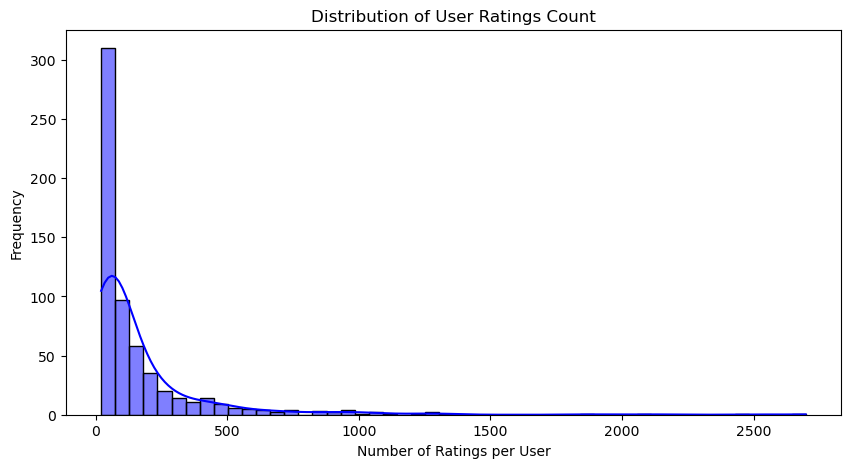

In [7]:
# Compute the number of ratings
user_rating_counts = ratings['userId'].value_counts()

plt.figure(figsize = (10, 5))
sns.histplot(user_rating_counts, bins = 50, kde = True, color = 'blue')
plt.xlabel("Number of Ratings per User")
plt.ylabel("Frequency")
plt.title("Distribution of User Ratings Count")
plt.show()

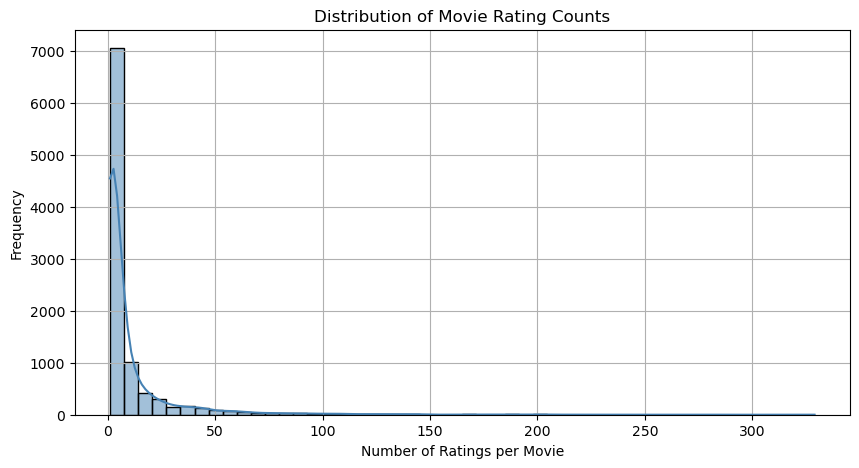

In [8]:
# Compute ratings per movie
movie_rating_counts = ratings['movieId'].value_counts()

plt.figure(figsize = (10, 5))
sns.histplot(movie_rating_counts, bins = 50, kde = True, color = 'steelblue')
plt.xlabel("Number of Ratings per Movie")
plt.ylabel("Frequency")
plt.title("Distribution of Movie Rating Counts")
plt.grid(True)

plt.show()

Plotting a Ratings Distribution visualization will also be helpful in understanding whether users tend to give positive, neutral or negative ratings.

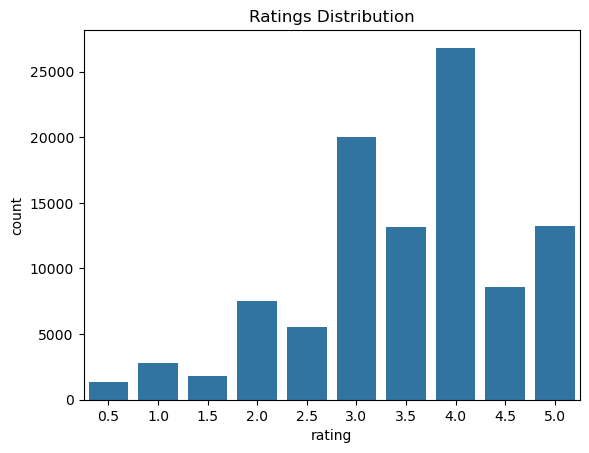

In [9]:
sns.countplot(x = 'rating', data = ratings)
plt.title('Ratings Distribution')
plt.show()

In [10]:
# Average movie rating
print('average movie rating: ', round(ratings['rating'].mean(), 2))

average movie rating:  3.5


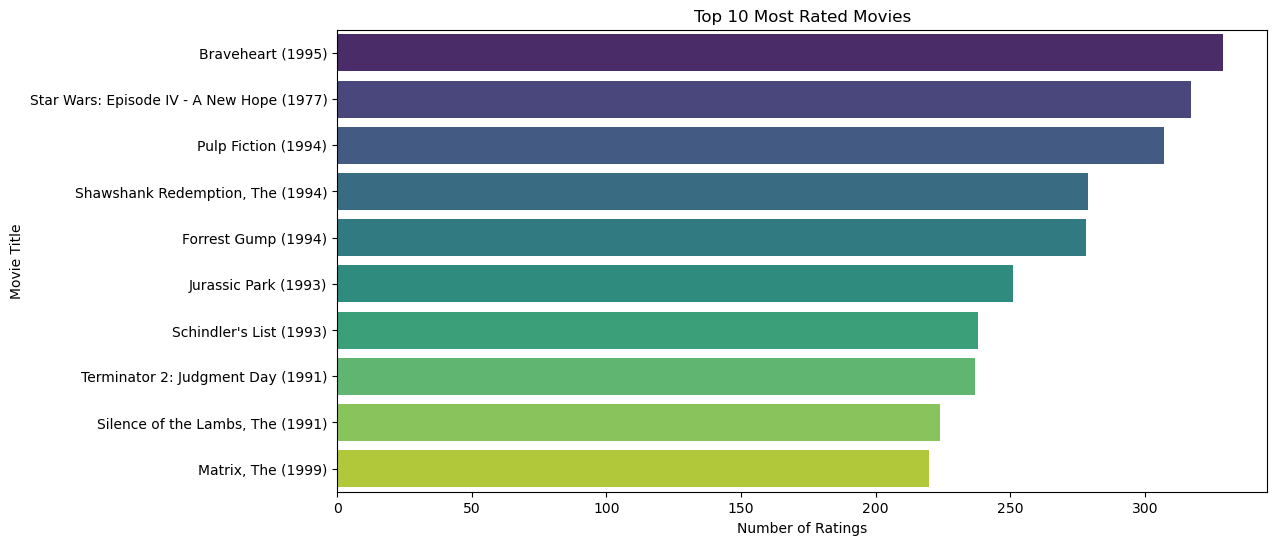

In [11]:
# Get top 10 most rated movies
top_movies = ratings['movieId'].value_counts().head(10).index
top_movies_df = movies[movies['movieId'].isin(top_movies)].copy()
top_movies_df['num_ratings'] = ratings[ratings['movieId'].isin(top_movies)]['movieId'].value_counts().values

plt.figure(figsize = (12, 6))
sns.barplot(x = 'num_ratings', y = 'title', data = top_movies_df, palette = 'viridis',
            hue = 'title', legend = False)
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")
plt.title("Top 10 Most Rated Movies")
plt.show()

The top 10 movies received 2680 out of the ~100,000 ratings in the dataset.

**Highest and Lowest Rated Movies**

In [12]:
# Merging the ratings and movies dataframes
movie_ratings = ratings.merge(movies, on = 'movieId')
movie_ratings

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...
100831,610,166534,4.0,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,Get Out (2017),Horror
100834,610,168252,5.0,Logan (2017),Action|Sci-Fi


In [13]:
# Finding the lowest rated movie
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()

movies[movies['movieId'] == lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [14]:
# Finding the number of ratings for the lowest rated movie
ratings[ratings['movieId'] == lowest_rated]

,userId,movieId,rating
13633,89,3604,0.5


The lowest rated movie only has one rating.

In [15]:
# Finding the highest rated movie
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [16]:
ratings[ratings['movieId'] == highest_rated]

,userId,movieId,rating
13368,85,53,5.0
96115,603,53,5.0


The highest rated movie only has two ratings

In [17]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats.columns = ['count', 'mean_rating']
movie_stats.head()

,count,mean_rating
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


Since a simple average may not tell the full story for movies with few ratings, a better approach to evaluating movie popularity is using the [Bayesian Average.](https://en.wikipedia.org/wiki/Bayesian_average#:~:text=A%20Bayesian%20average%20is%20a,available%20data%20set%20is%20small.) which smooths the ratings by pulling them towards the global average(m).

$$
\text{Bayesian Avg} = \frac{C \cdot m + \sum \text{ratings}}{C + n}
$$

Where:
- **𝐶:** The prior count (also called the weight). This is the average number of ratings per movie across the dataset.
- **𝑚:** The prior mean (expected value). This is the average rating across all movies in the dataset.
- **∑ ratings:** The sum of all ratings for a specific movie.
- **𝑛:** The number of ratings for that specific movie.

In [18]:
C = movie_stats['count'].mean()
m = movie_stats['mean_rating'].mean()

print(f'average number of ratings for a certain movie: {C}')
print(f'average rating for a certain movie: {m}')

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ ratings.count())
    return bayesian_avg

average number of ratings for a certain movie: 10.369806663924312
average rating for a certain movie: 3.262448274810963


Now to find the bayesian average rating for a movie that only has two ratings, both being 5

In [19]:
sample = pd.Series([5, 5])
bayesian_avg(sample)

3.5433826131392228

This shows that 'Lamerica' is not truly the highest rated movie and 'Gypsy' is not truly the lowest rated movie. They just have very few ratings. The next step is to find the bayesian average for all movies and to find the Highest and Lowest rated movies

In [20]:
# Finding the Bayesian Average for all movies
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = bayesian_avg_ratings.merge(movie_stats, on = 'movieId')
bayesian_avg_ratings

,movieId,bayesian_avg
0,1,3.890632
1,2,3.417227
2,3,3.260086
3,4,2.897612
4,5,3.104793
...,...,...
9719,193581,3.327318
9720,193583,3.283341
9721,193585,3.283341
9722,193587,3.283341


In [21]:
# Finding the Highest rated and Lowest rated movies
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values(by = 'bayesian_avg', ascending = False)

,movieId,bayesian_avg,count,mean_rating,title
277,318,4.392070,317,4.429022,"Shawshank Redemption, The (1994)"
659,858,4.236457,192,4.289062,"Godfather, The (1972)"
2224,2959,4.227052,218,4.272936,Fight Club (1999)
224,260,4.192646,251,4.231076,Star Wars: Episode IV - A New Hope (1977)
46,50,4.190567,204,4.237745,"Usual Suspects, The (1995)"
...,...,...,...,...,...
1988,2643,2.306841,16,1.687500,Superman IV: The Quest for Peace (1987)
1144,1499,2.296800,27,1.925926,Anaconda (1997)
1372,1882,2.267268,33,1.954545,Godzilla (1998)
2679,3593,2.224426,19,1.657895,Battlefield Earth (2000)


This makes much more sense since the highest rated movies are all pretty famous and well received movies.

**Movie Genres**

In [22]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Processing Movie Genres
The genres column is separated by '|'. For analysis, the genres are split into lists.

In [23]:
# Splitting genres into lists
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [24]:
# Count occurrences of each genre across all movies and print unique genres
genre_counts = Counter([g for genre in movies['genres'] for g in genre])
print(len(genre_counts))

genre_counts

20


Counter({'Drama': 4361,
         'Comedy': 3756,
         'Thriller': 1894,
         'Action': 1828,
         'Romance': 1596,
         'Adventure': 1263,
         'Crime': 1199,
         'Sci-Fi': 980,
         'Horror': 978,
         'Fantasy': 779,
         'Children': 664,
         'Animation': 611,
         'Mystery': 573,
         'Documentary': 440,
         'War': 382,
         'Musical': 334,
         'Western': 167,
         'IMAX': 158,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [25]:
genre_counts_df = pd.DataFrame([genre_counts]).T.reset_index()
genre_counts_df.columns = ['genre', 'count']
genre_counts_df

,genre,count
0,Adventure,1263
1,Animation,611
2,Children,664
3,Comedy,3756
4,Fantasy,779
5,Romance,1596
6,Drama,4361
7,Action,1828
8,Crime,1199
9,Thriller,1894


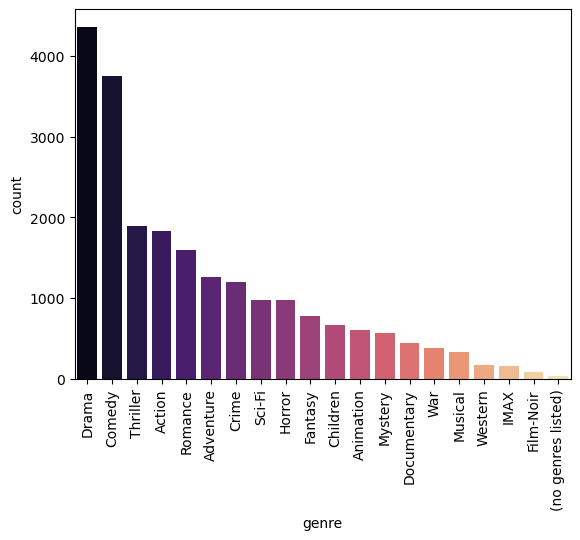

In [26]:
# Plotting the frequency of each movie genre
sns.barplot(x = 'genre', y = 'count', data = genre_counts_df.sort_values(by = 'count', ascending = False), palette = 'magma',
            hue = 'genre', legend = False)
plt.xticks(rotation = 90)
plt.show()

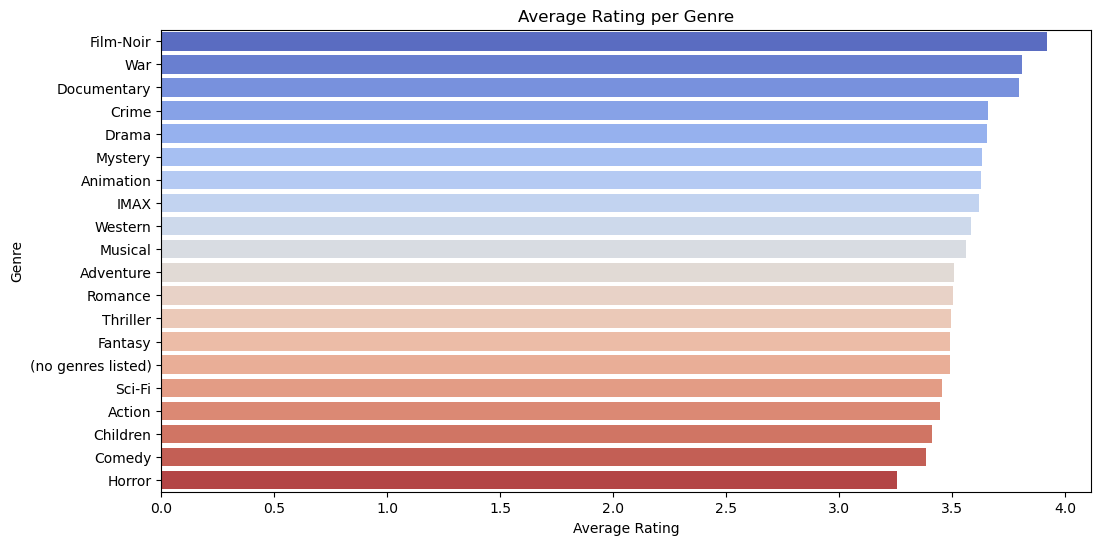

In [27]:
# To find the average rating per Genre
movie_ratings = movie_ratings.assign(genres = movie_ratings["genres"].str.split("|")).explode("genres")

genre_avg_ratings = movie_ratings.groupby("genres")["rating"].mean().sort_values(ascending = False)

# Plotting
plt.figure(figsize = (12, 6))
sns.barplot(x = genre_avg_ratings.values, y = genre_avg_ratings.index, palette = 'coolwarm',
             hue = genre_avg_ratings.index, legend = False)
plt.xlabel("Average Rating")
plt.ylabel("Genre")
plt.title("Average Rating per Genre")
plt.show()


# Modeling
**Creating a Recommendation Model**  
The next step is to build a recommendation model by first implementing CF using SVD. The model is then evaluated using cross validation, measuring RMSE and MAE.

In [28]:
# Initializing reader object for surprise.
reader = Reader()
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Initialize SVD model.
model = SVD()

# 5-fold cross validation.
simple_svd_score = cross_validate(model, data, cv = 5, measures = ['MAE', 'RMSE'], verbose = True)

mean_rmse = np.mean(simple_svd_score['test_rmse'])
mean_mae = np.mean(simple_svd_score['test_mae'])


print(f"Final Mean RMSE: {mean_rmse:.4f}")
print(f"Final Mean MAE: {mean_mae:.4f}")

Evaluating MAE, RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     0.6733  0.6720  0.6726  0.6630  0.6729  0.6708  0.0039  
RMSE (testset)    0.8729  0.8780  0.8783  0.8618  0.8758  0.8734  0.0061  
Fit time          1.82    1.17    1.20    1.12    1.28    1.32    0.26    
Test time         0.19    0.17    0.13    0.11    0.12    0.14    0.03    
Final Mean RMSE: 0.8734
Final Mean MAE: 0.6708


The model has a mean RMSE of 0.87 and a mean MAE of 0.67. These are good scores and the next step is to try and improve the scores by hypertuning the hyperparameters using GridSearchCV.

In [29]:
# Grid of hyperparameters to search over
param_grid = {
    'n_factors': [20, 50, 70, 100],
    'n_epochs': [10, 20], 
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.05, 0.1]
}

# GridSearch cross validation
gs = GridSearchCV(SVD, param_grid, measures=['RMSE', 'MAE'], cv=5)
gs.fit(data)

# Obtaining the best parameters
best_params = gs.best_params['rmse']
print("Best parameters:", best_params)

print(f"Best RMSE: {gs.best_score['rmse']:.4f}")
print(f"Best MAE: {gs.best_score['mae']:.4f}")

Best parameters: {'n_factors': 70, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.05}
Best RMSE: 0.8686
Best MAE: 0.6677


After hyperparameter tuning, the best model has similar values to the base SVD model. A  new model is trained using these best parameters and its performance evaluated using cross-validation.

In [30]:
# Use the best hyperparameters used in GridSearch
best_model = SVD(**best_params)
cross_val_results = cross_validate(best_model, data, cv = 5, measures = ['RMSE', 'MAE'], verbose = True)

mean_rmse = np.mean(cross_val_results['test_rmse'])
mean_mae = np.mean(cross_val_results['test_mae'])

print(f"Final Mean RMSE: {mean_rmse:.4f}")
print(f"Final Mean MAE: {mean_mae:.4f}")

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8587  0.8708  0.8687  0.8758  0.8709  0.8690  0.0056  
MAE (testset)     0.6601  0.6689  0.6640  0.6738  0.6709  0.6675  0.0049  
Fit time          1.27    1.03    0.97    1.08    1.07    1.08    0.10    
Test time         0.22    0.15    0.14    0.13    0.15    0.16    0.03    
Final Mean RMSE: 0.8690
Final Mean MAE: 0.6675


**Generating SVD predictions**  
The next step is to create a function that takes a user ID and generates the predicted ratings for all movies in the dataset using the SVD model.

In [31]:
def get_svd_predictions(user_id, movies, ratings, best_model):

    """
    Parameters:
    User_Id: The Id of the user
    movies: The movies dataset with movie IDs and titles
    ratings: The ratings dataset (not used but included for consistency)
    best_model: The model with the best gridsearchcv parameters
    """

    # Get all unique movie IDs from the movies dataset.
    all_movie_ids = movies['movieId'].unique()

    # Predict ratings for all movies using the SVD model.
    predictions = [best_model.predict(uid = user_id, iid = mid) for mid in all_movie_ids]

    # Creating a DataFrame containing the predicted ratings.
    pred_df = pd.DataFrame([(pred.iid, pred.est) for pred in predictions], columns = ['movieId', 'svd_score'])

    # merging the two dataframes to include movie titles for readability.
    pred_df = pred_df.merge(movies[['movieId', 'title']], on = 'movieId')

    return pred_df

In [32]:
get_svd_predictions(5, movies, ratings, best_model)

,movieId,svd_score,title
0,1,3.768412,Toy Story (1995)
1,2,3.378895,Jumanji (1995)
2,3,3.093601,Grumpier Old Men (1995)
3,4,2.828320,Waiting to Exhale (1995)
4,5,2.867023,Father of the Bride Part II (1995)
...,...,...,...
9737,193581,3.352624,Black Butler: Book of the Atlantic (2017)
9738,193583,3.274944,No Game No Life: Zero (2017)
9739,193585,3.360614,Flint (2017)
9740,193587,3.363864,Bungo Stray Dogs: Dead Apple (2018)


These are the predicted ratings for user with userId 5

**Computing Genre Similarity and Finding Similar Movies**  
To incorporate content-based filtering, we compute the similarity between movies based on their genres. This allows us to recommend movies that share similar genre characteristics.

In [33]:
def compute_genre_similarity(movies):

    # Ohe using MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    genre_matrix = mlb.fit_transform(movies['genres'])

    # Calculating genre similarity between movies
    genre_similarity = cosine_similarity(genre_matrix, genre_matrix)

    return genre_similarity

# Function to find similar movies:
def get_similar(movie, movies, genre_similarity, top_n = 5):
    
    """
    Finds movies most similar to a given movie based on genre.

    Parameters:
    movie: The title of the given movie.
    movies: The movies dataset.
    genre_similarity: Precomputed genre similarity matrix.
    top_n: The number of similar movies to return.
    """
    # Check if movie is in the dataset
    if movie not in movies['title'].values:
        return "Movie Not Found" 
    
    #get indices of the top similar movies
    movie_idx = movies.index[movies['title'] == movie][0]
    similar_indices = genre_similarity[movie_idx].argsort()[::-1][1:top_n + 1]

    return movies.iloc[similar_indices][['title', 'genres']]

# compute genre similarity matrix
similar_genres = compute_genre_similarity(movies)

recommended_movies = get_similar("Toy Story (1995)", movies, similar_genres)
recommended_movies

,title,genres
8219,Turbo (2013),"[Adventure, Animation, Children, Comedy, Fantasy]"
3568,"Monsters, Inc. (2001)","[Adventure, Animation, Children, Comedy, Fantasy]"
9430,Moana (2016),"[Adventure, Animation, Children, Comedy, Fantasy]"
3000,"Emperor's New Groove, The (2000)","[Adventure, Animation, Children, Comedy, Fantasy]"
2809,"Adventures of Rocky and Bullwinkle, The (2000)","[Adventure, Animation, Children, Comedy, Fantasy]"


The output represents the movies similar to "Toy Story".

**Cold Start Handling**
To make this work for new users, we'll use genre based filtering where instead of using ratings, the movies will be recommended based on global genre popularity. For returning users, their past ratings will be used to compute personalized genre scores.

In [ ]:
# Compute genre-based scores for a user based on their past ratings and genre similarity
def get_genre_scores(user_id, ratings,  movies, genre_similarity):
    # Get movies the user has rated
    user_movies = ratings[ratings['userId'] == user_id].merge(movies, on = 'movieId')
    
    if user_movies.empty:
        print(f"user {user_id} has no ratings, using global genre preferences.")
        
        # Computing global average genre score
        global_genre_scores = np.mean(genre_similarity, axis = 0)

        genre_df = pd.DataFrame({
            'movieId': movies['movieId'], 
            'title': movies['title'],
            'genre_score': global_genre_scores
        })

        return genre_df
    
    # Compute genre similarity scores
    genre_scores = np.zeros(len(movies))

    for movie_id in user_movies['movieId']:
        movie_idx = movies.index[movies['movieId'] == movie_id][0]
        genre_scores += genre_similarity[movie_idx] * user_movies[user_movies['movieId'] == movie_id]['rating'].values[0]

    # Normalize
    genre_scores /= len(user_movies)
    
    # Create DataFrame
    genre_df = pd.DataFrame({
        'movieId': movies['movieId'], 
        'title': movies['title'],
        'genre_score': genre_scores
    })

    return genre_df

genre_similarity = compute_genre_similarity(movies)

get_genre_scores(999999, ratings, movies, genre_similarity)

user 999999 has no ratings, using global genre preferences.


,movieId,title,genre_score
0,1,Toy Story (1995),0.208391
1,2,Jumanji (1995),0.088743
2,3,Grumpier Old Men (1995),0.268527
3,4,Waiting to Exhale (1995),0.403241
4,5,Father of the Bride Part II (1995),0.276886
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),0.232424
9738,193583,No Game No Life: Zero (2017),0.205447
9739,193585,Flint (2017),0.318679
9740,193587,Bungo Stray Dogs: Dead Apple (2018),0.102097


The output represents genre-based scores for user 3 based on their past ratings and genre similarity.

**Hybrid Recommendation System**  
To improve recommendation quality, CF (SVD) is blended with CBF (genre similarity). This hybrid approach balances personalized predictions with genre-based similarities, helping address the cold start problem for new users.

The final score for each movie is calculated using the formula:
$$
\text{final score} = \alpha \times \text{SVD score} + (1 - \alpha) \times \text{Genre score}
$$
where 
𝛼 controls the weight of CF vs. CBF.

In [46]:
def hybrid_recommendations(user_id, movies, ratings, best_model, genre_similarity, alpha = 0.5):
    
    # Getting CF (SVD) and CBF (genre_similarity) predictions for the user
    svd_df = get_svd_predictions(user_id, movies, ratings, best_model)
    genre_df = get_genre_scores(user_id, ratings, movies, genre_similarity)

    # merging both dataframes
    hybrid_df = svd_df.merge(genre_df, on = 'movieId')

    # Computing final score (weighted blend)
    hybrid_df['final_score'] = alpha * hybrid_df['svd_score'] + (1 - alpha) * hybrid_df['genre_score']

    # Get top recommendations
    top_movies = hybrid_df.sort_values(by = 'final_score', ascending = False).head(10)

    top_movies = top_movies.merge(movies[['movieId', 'title']], on = 'movieId')

    return top_movies[['movieId', 'title', 'final_score']]



In [47]:
# Generating recommendations for multiple users.
results = []

for i in range(1, 30):
    recommendations = hybrid_recommendations(i, movies, ratings, best_model, genre_similarity, 0.7)
    recommendations['userId'] = i
    results.append(recommendations)

final_df = pd.concat(results)

print(final_df)

    movieId                                        title  final_score  userId
0      2019  Seven Samurai (Shichinin no samurai) (1954)     3.923446       1
1      6016          City of God (Cidade de Deus) (2002)     3.896529       1
2      1262                     Great Escape, The (1963)     3.892829       1
3      1197                   Princess Bride, The (1987)     3.882254       1
4      1261           Evil Dead II (Dead by Dawn) (1987)     3.864781       1
..      ...                                          ...          ...     ...
5      3508               Outlaw Josey Wales, The (1976)     3.665207      29
6      6016          City of God (Cidade de Deus) (2002)     3.655793      29
7      1225                               Amadeus (1984)     3.652952      29
8      1217                                   Ran (1985)     3.651585      29
9      1208                        Apocalypse Now (1979)     3.647725      29

[290 rows x 4 columns]


These are the movie recommendations for the selected users.

**Evaluating SVD model performance**
The predicted ratings for the SVD model are compared with the actual user ratings. The function below retrieves predicted ratings for a user then merges these predictions with actual ratings to calculate the RMSE and MAE.

In [57]:
def evaluate_svd(user_id, movies, ratings, best_model):
    # Get SVD predictions for all movies
    svd_df = get_svd_predictions(user_id, movies, ratings, best_model)

    # Get the actual user ratings
    user_actual_ratings = ratings[ratings['userId'] == user_id][['movieId', 'rating']]
    
    # Skip if user has no rated movies in the dataset
    merged_df = svd_df.merge(user_actual_ratings, on = 'movieId')

    if merged_df.empty:
        print(f"No common movies found for user {user_id}. Skipping evaluation.")
        return None, None

    # Calculating RMSE and MAE
    rmse = np.sqrt(mean_squared_error(merged_df['rating'], merged_df['svd_score']))
    mae = mean_absolute_error(merged_df['rating'], merged_df['svd_score'])

    return merged_df, rmse, mae

svd_results, svd_rmse, svd_mae = evaluate_svd(35, movies, ratings, best_model)
print(f"SVD RMSE: {svd_rmse}, SVD MAE: {svd_mae}")

SVD RMSE: 0.7362503662498114, SVD MAE: 0.5810239217833173


The RMSE and MAE for the SVD model predictions for user 35

**Evaluating Hybrid Model Performance**
The function below calculates the RMSE and MAE by merging hybrid model predictions with the user's actual ratings.

In [64]:
def evaluate_hybrid(user_id, movies, ratings, best_model, genre_similarity, alpha = 0.7):
    
    """
    best_model: Trained SVD model for CF.
    genre_similarity: Cosine similarity matrix for genres.
    alpha: Weight parameter to balance SVD and genre-based filtering.
    """
    # Get hybrid recommendations for a user
    hybrid_df = hybrid_recommendations(user_id, movies, ratings, best_model, genre_similarity, alpha)
    
    # Accessing the actual user ratings
    user_actual_ratings = ratings[ratings['userId'] == user_id][['movieId', 'rating']]
    
    # Merging predictions with actual ratings
    merged_df = hybrid_df.merge(user_actual_ratings, on = 'movieId')

    # Skip if merged dataframe is empty
    if merged_df.empty:
        print(f"No common movies found for user {user_id}. Skipping evaluation.")
        return None, None, None

    # Calculate the RMSE and MAE
    rmse = np.sqrt(mean_squared_error(merged_df['rating'], merged_df['final_score']))
    mae = mean_absolute_error(merged_df['rating'], merged_df['final_score'])

    return merged_df, rmse, mae

hybrid_results, hybrid_rmse, hybrid_mae = evaluate_hybrid(300, movies, ratings, best_model, genre_similarity)

print(hybrid_results)
print(f" Hybrid RMSE: {hybrid_rmse}, Hybrid MAE: {hybrid_mae}")

   movieId                                       title  final_score  rating
0   112552                             Whiplash (2014)     3.832721     4.5
1     2959                           Fight Club (1999)     3.805705     4.5
2     2324  Life Is Beautiful (La Vita è bella) (1997)     3.801157     5.0
 Hybrid RMSE: 0.8877933049470507, Hybrid MAE: 0.8534721985802777


The RMSE and MAE for the hybrid model prediction for user 300

In [80]:
# Select 10 random user IDs from the ratings dataset
random.seed(30)
random_user_ids = random.sample(ratings['userId'].unique().tolist(), 10)

# Store results
results = []

for user_id in random_user_ids:
    print(f"Evaluating for User {user_id}...")

    svd_results, svd_rmse, svd_mae = evaluate_svd(user_id, movies, ratings, best_model)
    hybrid_results, hybrid_rmse, hybrid_mae = evaluate_hybrid(user_id, movies, ratings, best_model, genre_similarity)

    results.append({
        "userId": user_id,
        "SVD RMSE": svd_rmse,
        "SVD MAE": svd_mae,
        "Hybrid RMSE": hybrid_rmse,
        "Hybrid MAE": hybrid_mae
    })

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)
print(results_df)

Evaluating for User 553...
Evaluating for User 297...
Evaluating for User 31...
Evaluating for User 216...
Evaluating for User 264...
Evaluating for User 50...
Evaluating for User 407...
Evaluating for User 386...
Evaluating for User 138...
Evaluating for User 84...
   userId  SVD RMSE   SVD MAE  Hybrid RMSE  Hybrid MAE
0     553  0.565809  0.478818     0.915531    0.914457
1     297  0.935748  0.800683     1.761863    1.686121
2      31  0.901840  0.719587     1.328725    1.328725
3     216  0.853494  0.725687     1.398096    1.322113
4     264  0.875810  0.713520     1.729710    1.729710
5      50  0.668597  0.540024     1.263308    1.180974
6     407  0.755975  0.646581     1.043373    0.925682
7     386  0.745474  0.571075     0.933692    0.771620
8     138  1.267595  1.096578     1.680074    1.680074
9      84  0.597200  0.466652     1.143785    1.043198


The next step to compare the performance of the model is to visualize the average RMSE and MAE for each model across randomly selected users which will help us understand the accuracy of the recommendations produced by each model in a more clear way. We'll use a barplot, scatter plot, and KDE plot.

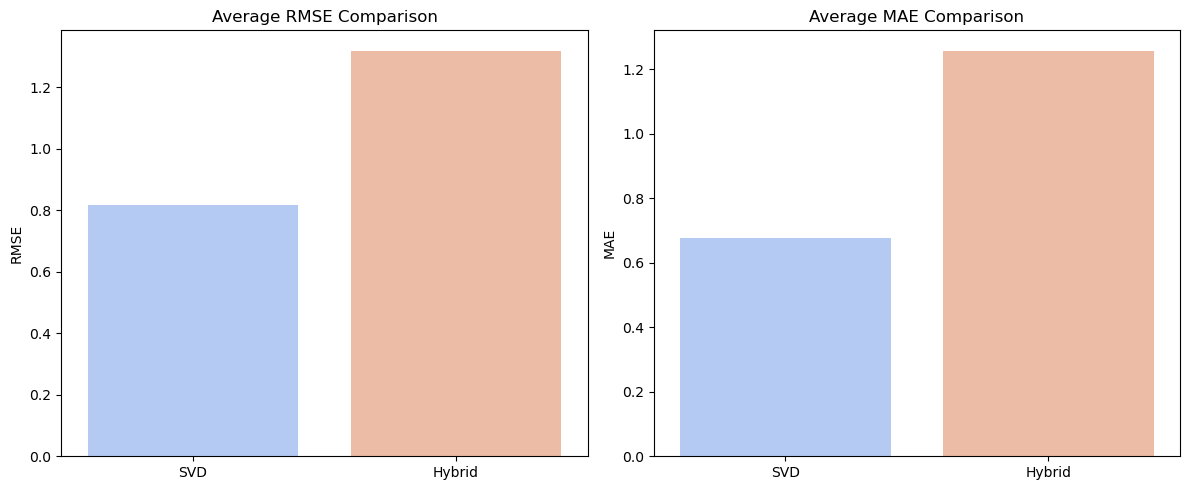

In [81]:
# Set up figure
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

# RMSE Comparison
sns.barplot(x = ["SVD", "Hybrid"], y = [results_df["SVD RMSE"].mean(), results_df["Hybrid RMSE"].mean()], ax = axes[0], palette = "coolwarm",
            hue = ["SVD", "Hybrid"])
axes[0].set_title("Average RMSE Comparison")
axes[0].set_ylabel("RMSE")

# MAE Comparison
sns.barplot(x = ["SVD", "Hybrid"], y=[results_df["SVD MAE"].mean(), results_df["Hybrid MAE"].mean()], ax = axes[1], palette = "coolwarm",
            hue = ["SVD", "Hybrid"])
axes[1].set_title("Average MAE Comparison")
axes[1].set_ylabel("MAE")

plt.tight_layout()
plt.show()

The SVD model has an average RMSE of ~0.8 and an average MAE of ~0.7 compared to the average RMSE and MAE of the Hybrid model which are ~1.3 and ~1.2 respectively. The SVD model outperforms the Hybrid model.

No common movies found for user 535. Skipping evaluation.
No common movies found for user 544. Skipping evaluation.
No common movies found for user 507. Skipping evaluation.
No common movies found for user 320. Skipping evaluation.
No common movies found for user 142. Skipping evaluation.


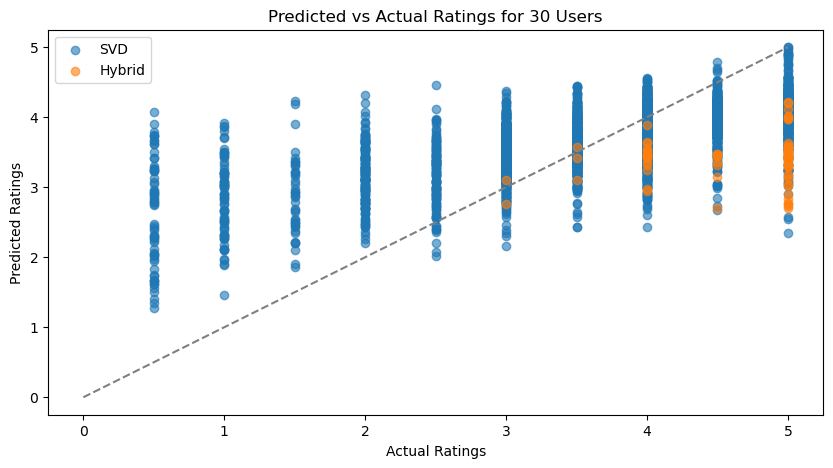

In [82]:
# Select 30 random user IDs
random_user_ids = random.sample(ratings['userId'].unique().tolist(), 30)

# Store merged results for all users
all_svd_merged = []
all_hybrid_merged = []

for user_id in random_user_ids:
    # Get predictions for the current user
    svd_results, _, _ = evaluate_svd(user_id, movies, ratings, best_model)
    hybrid_results, _, _ = evaluate_hybrid(user_id, movies, ratings, best_model, genre_similarity)

    # Making sure that user's rating exists for the movie
    if svd_results is not None and hybrid_results is not None:
        
        # Merge with actual ratings
        actual_ratings = ratings[ratings["userId"] == user_id][["movieId", "rating"]]
        svd_merged = svd_results.merge(actual_ratings, on = "movieId")
        hybrid_merged = hybrid_results.merge(actual_ratings, on = "movieId")

        # Append to the lists
        all_svd_merged.append(svd_merged)
        all_hybrid_merged.append(hybrid_merged)
    else:
        # If user does not have a rating for a movie
        print(f"Warning: No results found for User {user_id}. Skipping...")

# Concatenate results for all users
if all_svd_merged and all_hybrid_merged:
    svd_merged_all = pd.concat(all_svd_merged)
    hybrid_merged_all = pd.concat(all_hybrid_merged)

svd_merged_all = pd.concat(all_svd_merged)
hybrid_merged_all = pd.concat(all_hybrid_merged)

# Scatter plot for predictions vs actual ratings
plt.figure(figsize = (10, 5))
plt.scatter(svd_merged_all["rating_x"], svd_merged_all["svd_score"], label = "SVD", alpha = 0.6)
plt.scatter(hybrid_merged_all["rating_x"], hybrid_merged_all["final_score"], label = "Hybrid", alpha = 0.6)

plt.plot([0, 5], [0, 5], "--", color = "gray")
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Predicted vs Actual Ratings for 30 Users")
plt.legend()
plt.show()

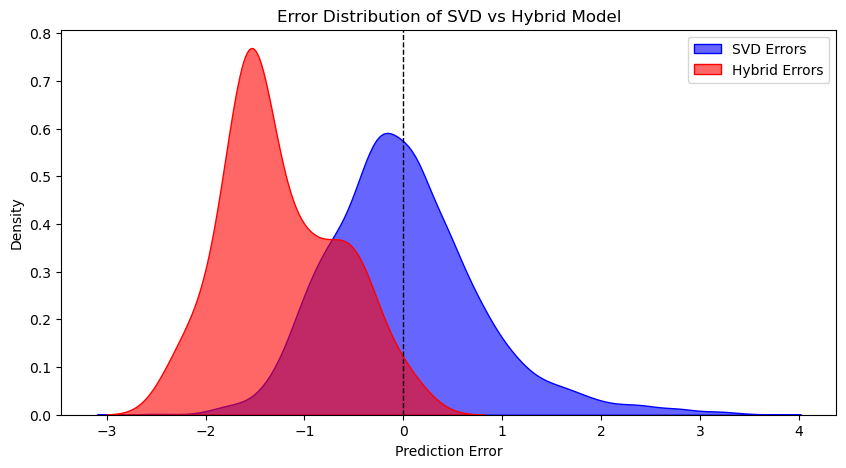

In [83]:
svd_errors = svd_merged_all["svd_score"] - svd_merged_all["rating_x"]
hybrid_errors = hybrid_merged_all["final_score"] - hybrid_merged_all["rating_x"]

plt.figure(figsize = (10, 5))
sns.kdeplot(svd_errors, label = "SVD Errors", fill = True, color = "blue", alpha = 0.6)
sns.kdeplot(hybrid_errors, label = "Hybrid Errors", fill = True, color = "red", alpha = 0.6)

plt.axvline(0, color = "black", linestyle = "dashed", linewidth = 1)
plt.xlabel("Prediction Error")
plt.ylabel("Density")
plt.title("Error Distribution of SVD vs Hybrid Model")
plt.legend()
plt.show()

The Hybrid Model appears to be biased negatively but appears to be more consistent and has lower error variance. Since the goal is to have errors closer to zero on average, the SVD model is more preferable but its spread suggests that it's inconsistent.

# Conclusion
In this Analysis, we evaluated the performance of different models for predicting movie ratings; SVD and a Hybrid model. Though the hybrid model was more consistent, the goal was to have errors close to zero on average which is why the SVD model is more preferable.

#### Next Steps:
- **Model Tuning:** Further hyperparameter tuning for both models.
- **Hybrid model enhancements:** Advanced hybridization techniques such as weighted blending or even adding more CBF should be considered to help reduce hybrid model's bias and improve performance.
- **Cold-Start Problem:** In the analysis, we attempted to solve the problem using global genre preference. Popularity-Based Recommendatoins should also be considered to try and address the problem.